1.  Logit 방식, SVM 방식 등 2가지의 방식을 이용하여 "survival"을 예측하는 classifier를 만들려고 한다.  Scikit-learn, Tensorflow, Keras 등 머신러닝 라이브러리를 이용하지 않고 classifier를 만들고 의미를 해석하라.

2. 구축된 classifier를 이용하여 predicted survival을 train_tatinic 내에서 만들고 실제 survival과 비교하여 예측 정확도를 각각 계산하라.

2. 2의 결과 중 2가지 방식 중 가장 좋은 예측력을 보이는 방식을 무엇인가? 그리고 그 이유는 무엇인가? (이론적으로 설명하라.)

In [ ]:
# 목차

# ------전처리----------
# 데이터 확인
# 데이터 변환
# 생존여부에 따른 변수값 확인
# 데이터 정규화
# 컬럼 수정
# 데이터 분할

# ------모형-------------
# 모형 만들기(경사하강법)
# cost, epoch, accuracy 확인
# 평가 및 예측
# 가중치 해석

# ------비교------------
# 라이브러리 모형 비교
# 모형 간 가중치 비교
# 샘플적용
      

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
path=r'C:\Users\imim555\iCloudDrive\KNU\DM\file\train_titanic.csv'
df=pd.read_csv(path)

# 데이터 확인-----------------------------------
 # 종속변수 확인
y_data=df['Survived']


 # 결측치 확인
df.isnull().sum()
df.value_counts

df=df.fillna(value={'Embarked':'S', 'Age':df['Age'].mean()}) 
df=df.round()


# 데이터 변환------------------------------------
# 카테고리형변수 수치화
df['Sex']=df['Sex'].map({'male':0, 'female':1}) 

df['PortS'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df['PortC'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

# 파생변수 생성
df['Family']=df['SibSp']+df['Parch'] 

                Age    Pclass    Family       Fare       Sex     PortS  \
Survived                                                                 
0         30.475410  2.531876  0.883424  22.136612  0.147541  0.777778   
1         28.596491  1.950292  0.938596  48.391813  0.681287  0.640351   

             PortC  
Survived            
0         0.136612  
1         0.271930  


 *Port값
S    646
C    168
Q     77
Name: Embarked, dtype: int64


 *Port별 생존자비율
Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64 


AxesSubplot(0.125,0.125;0.62x0.755)


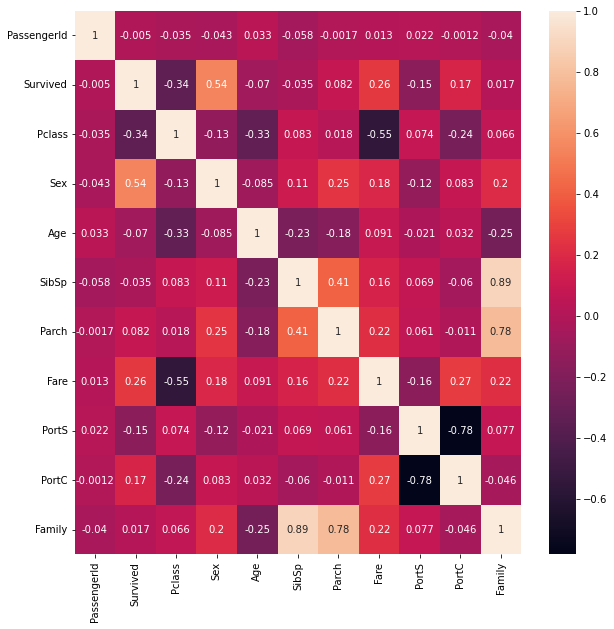

In [3]:
 # 생존여부에 따른 변수값 확인----------------------

mean=df.groupby(by=['Survived'])[['Age', 'Pclass','Family', 'Fare','Sex', 'PortS', 'PortC']].mean()
print(mean)

port1=df['Embarked'].value_counts() #C = Cherbourg, Q = Queenstown, S = Southampton
port2=df.groupby(by=['Embarked'])['Survived'].mean()
print(f'\n\n *Port값\n{port1}\n\n\n *Port별 생존자비율\n{port2} \n\n')

plt.subplots(figsize=(10,10))
cov=sns.heatmap(df.corr(),annot=True)
print(cov)

In [4]:
# 데이터 정규화--------------------------------

df0=df.copy() # 정규화X
df1=df.copy() # 정규화(Min-Max)


# Min-Max Normalization = (X - MIN) / (MAX-MIN) 
def Min_Max(x):
    min=x.min()
    max=x.max()
    normal=(x-min)/(max-min)
    return normal

age1=Min_Max(df['Age'])
fare1=Min_Max(df['Fare'])
family1=Min_Max(df['Family'])
pclass1=Min_Max(df['Pclass'])



# 컬럼 수정-----------------------------------
df1['age']=age1
df1['fare']=fare1
df1['family']=family1
df1['pclass']=pclass1


# 불필요한 변수 삭제
df1.drop(columns=['Survived','Name', 'PassengerId', 'Ticket','Cabin','Age','SibSp','Parch','Fare','Embarked','Family'], axis=1, inplace=True)
df0.drop(columns=['Survived','Name', 'PassengerId', 'Ticket','Cabin','SibSp','Parch','Embarked'], axis=1, inplace=True)


# 컬럼순서 변경
df0=df0[['Sex', 'Age', 'Family', 'Fare', 'Pclass', 'PortS','PortC' ]]
df1=df1[['Sex', 'age', 'family', 'fare', 'pclass', 'PortS','PortC' ]]


In [5]:
# 데이터 분할--------------------------------

# 종속/독립변수 나누기
y_data=y_data
x_data=df1

y_data=np.array(y_data)
x_data=np.array(x_data)



# 학습/검증용 나누기
size = y_data.shape[0] # 891

idx=np.arange(size)    # 일련번호 생성 후 재배열
np.random.shuffle(idx) 

num=int(size*0.7)      # 분리 비율(7:3)

x_train = x_data[idx[:num]] 
x_test = x_data[idx[num:]]
y_train = y_data[idx[:num]]
y_test = y_data[idx[num:]]


In [6]:
# 모형 만들기(경사하강법)-----------------------------

# 활성화함수
def sigmoid(z):    
    return 1/(1+np.exp(-z))


# 손실함수
def loss(w,b,x,y):
    global M,N
    
    M = x.shape[0]  # 데이터 갯수
    N = x.shape[1]  # 변수 갯수

    theta = np.dot(x,w)+b
    p = sigmoid(theta)
    diff = -(y*np.log(p)+(1-y)*np.log(1-p))  # 오차
    cost = np.sum(diff)/(M*N)  # 오차평균
    return p, cost
    
    
    
# 학습진행

    # 파라미터 초기화
iter=10000
rate=0.05
w=np.zeros(x_train.shape[1])
b=np.ones(1)

COST=[]
EPOCH=[]
ACCURACY=[]

for count in range(iter):
    p, cost=loss(w, b, x_train, y_train)
    
    # 기울기 구하기
    grad_w = np.dot((p-y_train),x_train)*1/(N*M)
    grad_b = np.sum(p-y_train)*1/(N*M)
    
    # 파라미터 갱신
    w = w-rate*grad_w
    b = b-rate*grad_b
    
    # 정확도
    P = np.where(p>0.5, 1, 0)
    predict = np.greater(p, 0.5)
    answer = np.greater(y_train, 0.5)
    test = np.equal(predict, answer)
    accuracy = np.mean(test)
    
    
    if count % 100 == 0:
        print(f'iter ={count}, cost ={np.round(cost,3)}, accuracy ={np.round(accuracy,2)}\n',
              f'grad_w ={np.round(grad_w,4)}\n',
              f'grad_b ={np.round(grad_b,4)}\n', 
              f'     w ={np.round(w,4)},\n',
              f'     b ={np.round(b,4)} \n')
        EPOCH.append(count)
        COST.append(cost)
        ACCURACY.append(accuracy)
      

iter =0, cost =0.133, accuracy =0.38
 grad_w =[-0.0013  0.0193  0.0045  0.0014  0.043   0.0421  0.0041]
 grad_b =0.0501
      w =[ 0.0001 -0.001  -0.0002 -0.0001 -0.0022 -0.0021 -0.0002],
      b =[0.9975] 

iter =100, cost =0.109, accuracy =0.38
 grad_w =[-0.0062  0.0137  0.003   0.0005  0.0319  0.0295  0.0023]
 grad_b =0.0347
      w =[ 0.0195 -0.0829 -0.0188 -0.0047 -0.1885 -0.1797 -0.0159],
      b =[0.787] 

iter =200, cost =0.097, accuracy =0.63
 grad_w =[-0.0096  0.0094  0.0019 -0.      0.0234  0.0199  0.0011]
 grad_b =0.0232
      w =[ 0.0597 -0.14   -0.0308 -0.0059 -0.3255 -0.3016 -0.0241],
      b =[0.6444] 

iter =300, cost =0.091, accuracy =0.69
 grad_w =[-0.0117  0.0066  0.0012 -0.0004  0.0177  0.0135  0.0003]
 grad_b =0.0154
      w =[ 0.1134 -0.1795 -0.0383 -0.0046 -0.4272 -0.3838 -0.0272],
      b =[0.5496] 

iter =400, cost =0.087, accuracy =0.74
 grad_w =[-0.0128  0.0047  0.0007 -0.0007  0.0138  0.0093 -0.0002]
 grad_b =0.0103
      w =[ 0.175  -0.2074 -0.0429 -0.0018

iter =6700, cost =0.063, accuracy =0.81
 grad_w =[-0.0024  0.0008  0.0006 -0.0002  0.0015 -0.0003 -0.0001]
 grad_b =-0.0
      w =[ 2.2336 -0.5709 -0.1655  0.1363 -1.5965 -0.5638  0.0541],
      b =[0.2737] 

iter =6800, cost =0.063, accuracy =0.8
 grad_w =[-0.0023  0.0008  0.0006 -0.0002  0.0015 -0.0003 -0.0002]
 grad_b =-0.0
      w =[ 2.2454 -0.575  -0.1684  0.1372 -1.6039 -0.5625  0.0549],
      b =[0.2739] 

iter =6900, cost =0.063, accuracy =0.8
 grad_w =[-0.0023  0.0008  0.0006 -0.0002  0.0014 -0.0003 -0.0002]
 grad_b =-0.0001
      w =[ 2.2569 -0.5792 -0.1714  0.1381 -1.6112 -0.5611  0.0556],
      b =[0.2741] 

iter =7000, cost =0.063, accuracy =0.8
 grad_w =[-0.0022  0.0008  0.0006 -0.0002  0.0014 -0.0003 -0.0002]
 grad_b =-0.0001
      w =[ 2.2681 -0.5833 -0.1744  0.1389 -1.6183 -0.5598  0.0564],
      b =[0.2744] 

iter =7100, cost =0.063, accuracy =0.8
 grad_w =[-0.0022  0.0008  0.0006 -0.0002  0.0014 -0.0003 -0.0002]
 grad_b =-0.0001
      w =[ 2.279  -0.5875 -0.1775  0.1

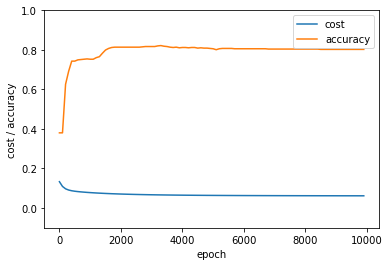

In [7]:
# cost, epoch, accuracy 확인 ------------------

plt.plot(EPOCH, COST, label='cost')
plt.plot(EPOCH, ACCURACY, label='accuracy')

plt.ylim(-0.1,1)

plt.xlabel('epoch')
plt.ylabel('cost / accuracy')
plt.legend()
plt.show()


In [8]:
# 평가 및 예측-------------------------------

# 예측하기
theta = np.dot(x_test,w)+b
p = sigmoid(theta)
predict=np.where(p>0.5, 1, 0)


# 평가하기
def score(predict, answer):
    
    predict = np.where(predict > 0.5, 1, 0)
    predict_T = np.greater(predict, 0.5)
    predict_F = np.logical_not(predict_T)
    answer_T = np.greater(answer, 0.5)
    answer_F = np.logical_not(answer_T)

    tp = np.sum(np.logical_and(predict_T, answer_T))
    tn = np.sum(np.logical_and(predict_F, answer_F))
    fp = np.sum(np.logical_and(predict_T, answer_F))
    fn = np.sum(np.logical_and(predict_F, answer_T))
    
    accuracy = (tp+tn)/(tp+fn+fp+tn)  
    precision = tp/(tp+fp)  
    recall = tp/(tp+fn)     
    f1 =  2*(precision*recall) / (precision+recall)
    
    return [round(accuracy,3), round(precision,3), round(recall,3), round(f1,3)], [tp,tn, fp,fn,]


print(f' 학습 {score(P, y_train)}\n',
      f'예측 {score(predict, y_test)}')

 학습 ([0.803, 0.748, 0.726, 0.737], [172, 328, 58, 65])
 예측 ([0.757, 0.692, 0.686, 0.689], [72, 131, 32, 33])


In [9]:
# 가중치 해석
feature=['bias', 'Sex', 'age', 'family', 'fare', 'pclass', 'PortS', 'PortC']
wb = np.concatenate((b,w),axis=None)
wb = np.round(wb,3)
odds = np.round(np.exp(wb),3)
per = np.round((odds-1),3)

wb_detail=np.vstack((wb,odds,per))
WB = pd.DataFrame(wb_detail, columns=feature, index=['coef','odds','per'])
WB

,bias,Sex,age,family,fare,pclass,PortS,PortC
coef,0.294,2.510,-0.701,-0.268,0.159,-1.790,-0.520,0.082
odds,1.342,12.305,0.496,0.765,1.172,0.167,0.595,1.085
per,0.342,11.305,-0.504,-0.235,0.172,-0.833,-0.405,0.085


In [10]:
# 라이브러리 모형 비교--------------------------------------

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


SK = LogisticRegression(fit_intercept=True) 
SK.fit(x_train, y_train)        
predict_SK = SK.predict(x_test) 
P_SK = SK.predict_proba(x_test)

print(f"  SKepoch={SK.max_iter}, rate={SK.tol}\n",
      f' SK학습: {SK.score(x_train, y_train)}\n',
      f' SK예측: {SK.score(x_test, y_test)}\n\n')
      #print(classification_report(y_test, predict_LR ))


# statsmodel
import statsmodels.api as sm

x_train1=sm.add_constant(x_train, has_constant='add') # 절편추가
logit = sm.Logit(y_train, x_train1)
SM = logit.fit()
     #print(SM.summary2())


  SKepoch=100, rate=0.0001
  SK학습: 0.8154093097913323
  SK예측: 0.7649253731343284


Optimization terminated successfully.
         Current function value: 0.417411
         Iterations 6


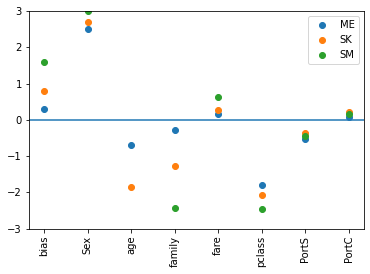

,bias,Sex,age,family,fare,pclass,PortS,PortC
me,0.294,2.510,-0.701,-0.268,0.159,-1.790,-0.520,0.082
SK,0.792,2.709,-1.844,-1.273,0.267,-2.085,-0.372,0.216
SM,1.584,2.993,-3.265,-2.430,0.617,-2.463,-0.436,0.152


In [11]:
# 모형 간 가중치 비교----------------------------

# 가중치

wb_LR=np.concatenate((SK.intercept_,SK.coef_), axis=None)
wb_SM=SM.params
WB=[wb, wb_LR, wb_SM]
weight=pd.DataFrame(WB, columns=feature, index=['me','SK','SM'])



# 시각화
plt.plot(wb, 'o', label='ME')
plt.plot(wb_LR, 'o', label='SK')
plt.plot(wb_SM, 'o', label='SM')

xlims=plt.xlim()
plt.xlim(xlims)
plt.ylim(-3,3)
plt.hlines(0, xlims[0], xlims[1])

plt.xticks(range(N+1), feature, rotation=90 )
plt.legend()
plt.show()


weight.round(3)

In [13]:
# 샘플적용-----------------------------------

# 샘플생성
              # Sex, age, family, fare, Pclass, PS, PC
Jack = np.array([0,   30,   0,     35,   3,     1,  0 ])
Rose = np.array([1,   20,   0,    500,   1,     0,  1 ])
pika = np.array([1,    7,   3,    500,   2,     0,  0 ])

sample = np.array([Jack, Rose, pika])
N = sample.shape[0]



# 샘플 정규화
def normal(sample, method):
    global res
    person=sample.shape[0]
    feature=sample.shape[1]
    res=[]
    if method == 1 :
        print('Min_Max')
        for p in range(person):
            res0=[]   
            for f in range(feature):
                x=df0.iloc[:,f]
                val=sample[p][f]
                output=(val-x.min())/(x.max()-x.min())
                res0.append(output)
            res.append(res0)
    
    else : print('정규화x')
    res=np.array(res)
        
normal(sample,1)


# 예측
 #ME
theta = np.dot(res,w)+b
p_sample = sigmoid(theta)
predict_sample =np.where(p_sample > 0.5, 1, 0)


 #SK
pred_SK=SK.predict(res)
pos_SK=SK.predict_proba(sample)


 #SM
bias=np.ones([res.shape[0]])
sample1=np.column_stack([bias, res])

pos_SM=SM.predict(sample1)
neg_SM=1-pos_SM
pred_SM =np.where(pos_SM>0.5,1,0)



print(f' ME \n',
      f'{predict_sample}\n',          # 생존여부
      f'{np.round(p_sample,2)}\n\n')  # 생존확률

print(f' SK \n',
      f'{pred_SK}\n',
      f'{np.round(pos_SK[:,1],4)}\n\n')

print(f' SM \n',
      f'{pred_SM}\n',
      f'{np.round(pos_SM,2)}\n\n')


Min_Max
 ME 
 [0 1 1]
 [0.09 0.95 0.87]


 SK 
 [0 1 1]
 [0. 1. 1.]


 SM 
 [0 1 1]
 [0.08 0.99 0.95]


